# Visualizing the Algorithm

To better understand how the algorithm works we will do some more visualization for it. First let's build three sets of data points that each have just two features.

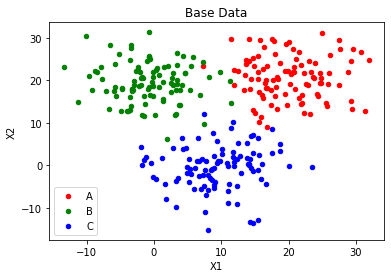

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)
A = pd.DataFrame(np.random.normal(0,5, (100,2)) + (20,20), columns=['X1', 'X2'])
B = pd.DataFrame(np.random.normal(0,5, (100,2)) + (0,20), columns=['X1', 'X2'])
C = pd.DataFrame(np.random.normal(0,5, (100,2)) + (10,0), columns=['X1', 'X2'])
fig, ax = plt.subplots()
A.plot.scatter(x='X1', y='X2', label='A', ax=ax, color='red')
B.plot.scatter(x='X1', y='X2', label='B', ax=ax, color='green')
C.plot.scatter(x='X1', y='X2', label='C', ax=ax, color='blue')
plt.title("Base Data")
plt.show()

Granted it is not reasonable to assume we will have the actual categories in the real world (and if we did we would not even need this), but this will be useful for understanding how the algorithm works. Regardless, fit the KMeans algorithm.

In [2]:
from sklearn.cluster import KMeans
X = pd.concat([A,B,C])
model = KMeans(n_clusters=3, random_state=0).fit(X)

To visualize this data, one thing we will want to do is to see what the boundaries are for the different groups. To achieve this, we need to find the at each point what the group would be. Meshgrid takes two 1D arrays and builds every combination of the values. This will allow us to grab a lot of x and y values across a grid. Intialize two arrays with numbers between -15 and 35 (the approx. bounds) and call np.meshgrid to get back all of the x and y points we want to test.

In [3]:
#Grab all the x and y points
x_grid, y_grid = np.meshgrid(np.linspace(-15, 35, 1000), np.linspace(-15, 35, 1000))
print(x_grid)
print()
print()
print(y_grid)

[[-15.         -14.94994995 -14.8998999  ...  34.8998999   34.94994995
   35.        ]
 [-15.         -14.94994995 -14.8998999  ...  34.8998999   34.94994995
   35.        ]
 [-15.         -14.94994995 -14.8998999  ...  34.8998999   34.94994995
   35.        ]
 ...
 [-15.         -14.94994995 -14.8998999  ...  34.8998999   34.94994995
   35.        ]
 [-15.         -14.94994995 -14.8998999  ...  34.8998999   34.94994995
   35.        ]
 [-15.         -14.94994995 -14.8998999  ...  34.8998999   34.94994995
   35.        ]]


[[-15.         -15.         -15.         ... -15.         -15.
  -15.        ]
 [-14.94994995 -14.94994995 -14.94994995 ... -14.94994995 -14.94994995
  -14.94994995]
 [-14.8998999  -14.8998999  -14.8998999  ... -14.8998999  -14.8998999
  -14.8998999 ]
 ...
 [ 34.8998999   34.8998999   34.8998999  ...  34.8998999   34.8998999
   34.8998999 ]
 [ 34.94994995  34.94994995  34.94994995 ...  34.94994995  34.94994995
   34.94994995]
 [ 35.          35.          35.        

For prediction, we are going to need a 2D array. The function ravel will take the arrays and break them down to 1D, and then from there we can stack and transpose to get our data for prediction.

In [4]:
print(np.vstack([x_grid.ravel(), y_grid.ravel()]).T)

[[-15.         -15.        ]
 [-14.94994995 -15.        ]
 [-14.8998999  -15.        ]
 ...
 [ 34.8998999   35.        ]
 [ 34.94994995  35.        ]
 [ 35.          35.        ]]


Now predict the labels for each point in the grid and reshape.

In [5]:
z = model.predict(np.vstack([x_grid.ravel(), y_grid.ravel()]).T)
z = z.reshape(x_grid.shape)
print(z)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]]


And plot, we can even pass in a colormap to match the colors of the data we created before. We use imshow passing in the prediction values with a few other options. For one we use extent to feed the boundaries of the area. As well, we use interpolation to make it so that we can interpolate between points. As well, a cmap or the color map is passed which holds the colors, alpha to make it less dark, and orgin of lower/aspect of auto to make it correctly align.

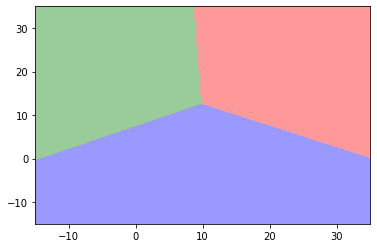

In [6]:
from matplotlib import colors

#Create the color map
cmap = colors.ListedColormap(['green', 'blue','red'])

#Plot the regions
plt.imshow(z, interpolation='nearest',
           extent=(-15, 35, -15, 35),
           cmap=cmap,
           alpha=.4,
           aspect='auto', origin='lower')

plt.show()

From here we can overlay the actual data to see how well the regions group the different pieces of data.

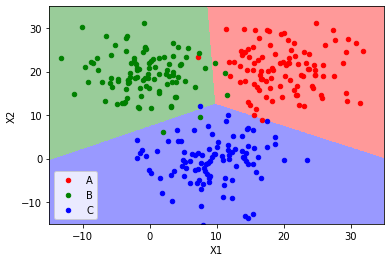

In [7]:
#Set up our plots
fig, ax = plt.subplots()

#Plot all the actual data
A.plot.scatter(x='X1', y='X2', label='A', ax=ax, color='red')
B.plot.scatter(x='X1', y='X2', label='B', ax=ax, color='green')
C.plot.scatter(x='X1', y='X2', label='C', ax=ax, color='blue')

#Plot the regions
ax.imshow(z, interpolation='nearest',
           extent=(-15, 35, -15, 35),
           cmap=cmap,
           alpha=.4,
           aspect='auto', origin='lower')

plt.show()

## Visualizing the Iterations

Now let's say that we are once again are starting from a random group of centroids. Let's re-define a function for finding the groups since we now need to do this stuff ourself. We'll check with a dummy point to make sure the output makes sense.

In [8]:
def find_groups(centroids, X):
    #Get the distance
    distance = [((X - c) ** 2).sum(axis=1) ** .5 for c in centroids]

    #Stack the distances
    distance = np.vstack(distance)

    #Find the groups
    groups = distance.argmin(axis=0)
    
    return groups

#Define centroids
centroids = [[-10,20],
    [15,7.5],[20,20]]

#Test a point out
print(find_groups(centroids, np.array([[-10.1, 20.1]])))

[0]


With that in mind we can find the full set of labels.

In [9]:
#Find all the labels in the grid
z = find_groups(centroids, np.vstack([x_grid.ravel(), y_grid.ravel()]).T)
z = z.reshape(x_grid.shape)
print(z)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]]


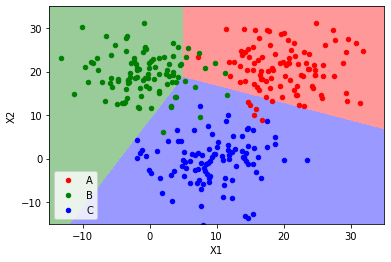

In [10]:
#Set up our plots
fig, ax = plt.subplots()

#Plot all the actual data
A.plot.scatter(x='X1', y='X2', label='A', ax=ax, color='red')
B.plot.scatter(x='X1', y='X2', label='B', ax=ax, color='green')
C.plot.scatter(x='X1', y='X2', label='C', ax=ax, color='blue')

#Plot the regions
ax.imshow(z, interpolation='nearest',
           extent=(-15, 35, -15, 35),
           cmap=cmap,
           alpha=.4,
           aspect='auto', origin='lower')

plt.show()

Below are re-define a few functions we have been using up until now which we will utilize in visualization of our algorithm. As well I am going to summarize our plotting functionality in a new function as well.

In [11]:
def find_groups(centroids, X):
    #Get the distance
    distance = [((X - c) ** 2).sum(axis=1) ** .5 for c in centroids]

    #Stack the distances
    distance = np.vstack(distance)

    #Find the groups
    groups = distance.argmin(axis=0)
    
    return groups

def compute_centroids(X, centroids, groups):
    #Find the centers
    centroids = [X[groups == l].mean(axis=0) for l in list(range(len(centroids)))]
    
    #Stack
    centroids = np.vstack(centroids)
    
    return centroids

def plot_clusters(A, B, C, x_grid, y_grid, centroids):
    #Find all the labels in the grid
    z = find_groups(centroids, np.vstack([x_grid.ravel(), y_grid.ravel()]).T)
    z = z.reshape(x_grid.shape)

    #Set up our plots
    fig, ax = plt.subplots()

    #Plot all the actual data
    A.plot.scatter(x='X1', y='X2', label='A', ax=ax, color='red')
    B.plot.scatter(x='X1', y='X2', label='B', ax=ax, color='green')
    C.plot.scatter(x='X1', y='X2', label='C', ax=ax, color='blue')

    #Plot the regions
    ax.imshow(z, interpolation='nearest',
               extent=(-15, 35, -15, 35),
               cmap=cmap,
               alpha=.4,
               aspect='auto', origin='lower')

    plt.show()

And now we can look at how the iteratiosn shift over time to convergence.

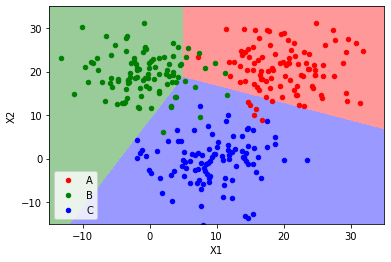

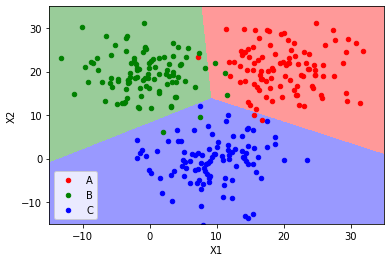

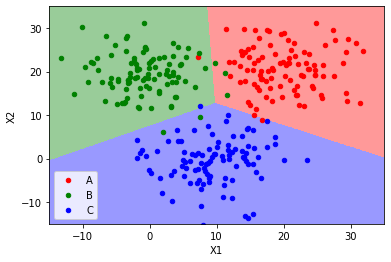

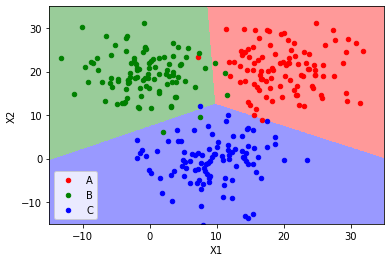

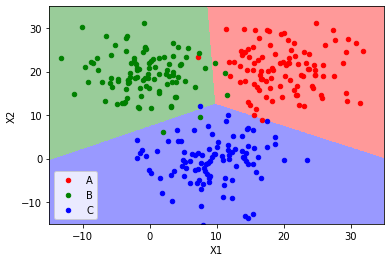

Converged after 4 iterations.


In [12]:
max_iter = 1000

#Start with labels as -1 meaning null
labels = np.ones(len(X)) * -1

#Define starting centroids
centroids = [[-10,20],
    [15,7.5],[20,20]]

plot_clusters(A, B, C, x_grid, y_grid, centroids)
num_iter = 0
for _ in range(max_iter):
    num_iter += 1
    
    #Hold onto the old labels
    old_labels = labels.copy()
    
    #Find labels and re-compute the centers
    labels = find_groups(centroids, X)
    centroids = compute_centroids(X, centroids, labels)
    
    #Plot results
    plot_clusters(A, B, C, x_grid, y_grid, centroids)
    
    #If all labels are the same, end the iteration
    if (labels == old_labels).all():
        break

print("Converged after {} iterations.".format(num_iter))

If we try another one we can once again see the path it takes to eventually get to convergence.

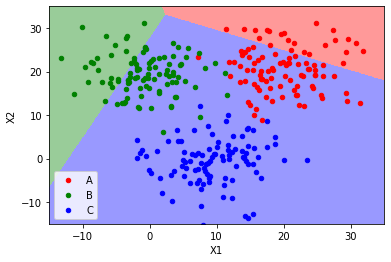

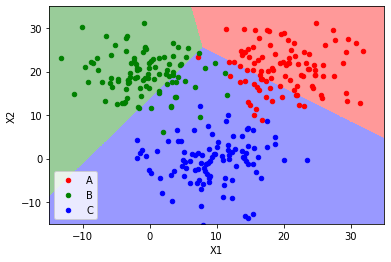

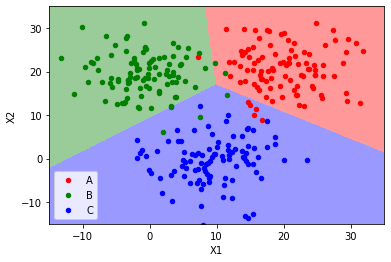

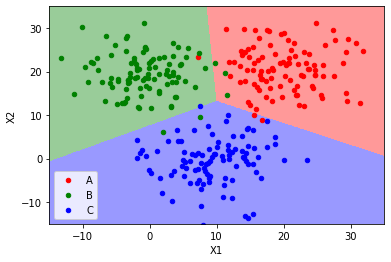

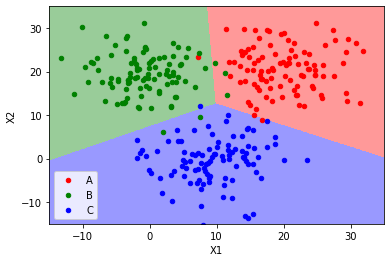

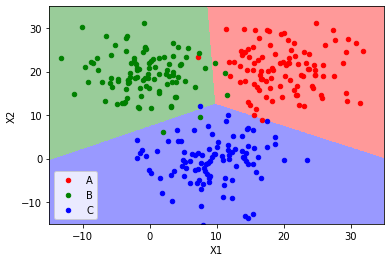

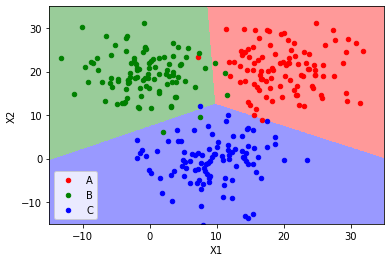

Converged after 6 iterations.


In [13]:
max_iter = 1000

#Start with labels as -1 meaning null
labels = np.ones(len(X)) * -1

#Define starting centroids
centroids = [[-25,25],
    [15,7.5],[30,40]]

plot_clusters(A, B, C, x_grid, y_grid, centroids)
num_iter = 0
for _ in range(max_iter):
    num_iter += 1
    
    #Hold onto the old labels
    old_labels = labels.copy()
    
    #Find labels and re-compute the centers
    labels = find_groups(centroids, X)
    centroids = compute_centroids(X, centroids, labels)
    
    #Plot results
    plot_clusters(A, B, C, x_grid, y_grid, centroids)
    
    #If all labels are the same, end the iteration
    if (labels == old_labels).all():
        break

print("Converged after {} iterations.".format(num_iter))